# **LIBRARY PREPARATION**

In [2]:
# 1. Import necessary libraries
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import DataFrame
from pandas import Grouper
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
# from dataprep.eda import plot, plot_correlation, plot_missing, create_report
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

# **NVL DATA PREPARATION**

In [3]:
# 9:1 ratio
df = pd.read_csv('NVL Historical Data 2018.csv') # Read data
df = df[['Price']]
df = df.dropna() # Drop NaN values
df = df[::-1] #Chronological order

df = df.reset_index(drop=True) # Reset the index

In [4]:
# Remove commas and convert to numeric in 'Price'
df['Price'] = df['Price'].str.replace(',', '').astype(float)

df

,Price
0,27815.0
1,28410.0
2,28707.0
3,28962.0
4,29556.0
...,...
1547,16700.0
1548,16500.0
1549,16550.0
1550,17100.0


# **Stationary Test using ADF Test**

In [5]:
# ADF Test Function
def adf_test(series,title=''):
    """ Input a time series and an optional title to return an ADF report """

    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data

    labels = ['ADF Test Statistic','p-value','# Lags used','# Observations']
    out = pd.Series(result[0:4],index = labels)

    for key,val in result[4].items():
        out[f'Critical Value ({key})'] = val
    print(out.to_string())          # .to_string() removes the line "dtype: float64"

    if result[1] <= 0.05:
        print("\nStrong evidence against the null hypothesis,\nReject the null hypothesi,\n --> Data has no unit root and is STATIONARY")
    else:
        print("\nWeak evidence against the null hypothesis,\nFail to reject the null hypothesis,\n --> nData has a unit root and is NON-STATIONARY")

In [6]:
adf_test(df['Price'], 'Stationarity')

Augmented Dickey-Fuller Test: Stationarity
ADF Test Statistic        -1.481550
p-value                    0.542618
# Lags used               11.000000
# Observations          1540.000000
Critical Value (1%)       -3.434603
Critical Value (5%)       -2.863419
Critical Value (10%)      -2.567770

Weak evidence against the null hypothesis,
Fail to reject the null hypothesis,
 --> nData has a unit root and is NON-STATIONARY


# **CONVERT TO STATIONARY TIME SERIES**

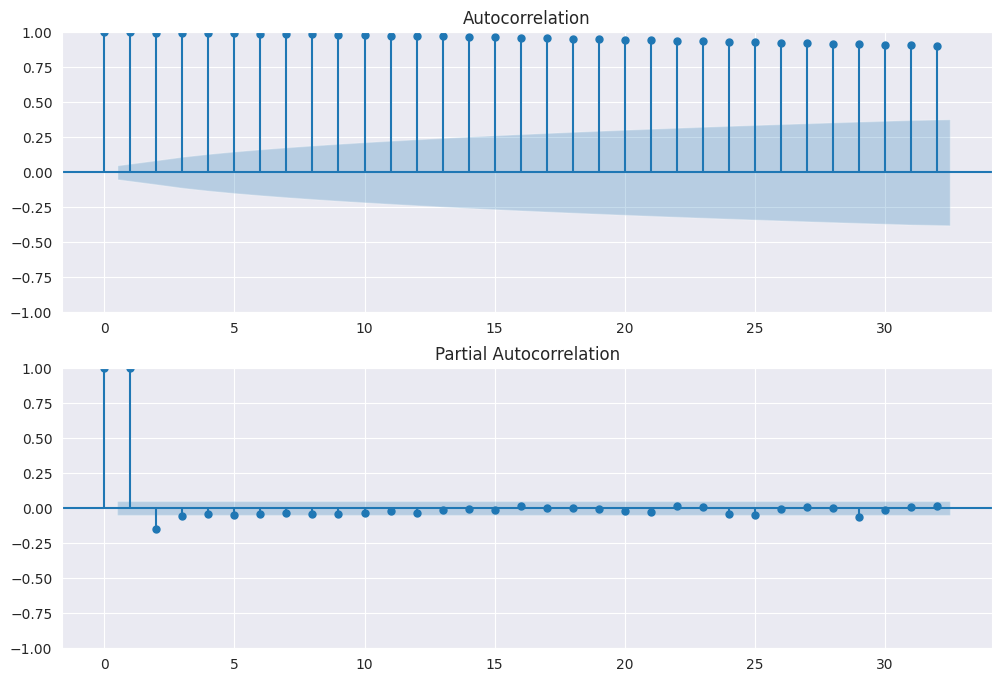

In [7]:
# Plotting the AutoCorrelation Function and Partial AutoCorrelation Function to determine ARIMA parameters.
fig, axes = plt.subplots(2, 1, figsize=(12,8))
plot_acf(df['Price'], ax=axes[0])
plot_pacf(df['Price'], ax=axes[1])
plt.show()

In [8]:
log_price = np.log(df['Price'])
log_diff = log_price.diff().dropna()

In [9]:
adf_test(log_diff, 'Stationarity')

Augmented Dickey-Fuller Test: Stationarity
ADF Test Statistic     -7.779370e+00
p-value                 8.498196e-12
# Lags used             1.000000e+01
# Observations          1.540000e+03
Critical Value (1%)    -3.434603e+00
Critical Value (5%)    -2.863419e+00
Critical Value (10%)   -2.567770e+00

Strong evidence against the null hypothesis,
Reject the null hypothesi,
 --> Data has no unit root and is STATIONARY


# **TRAIN-TEST SPLIT**

In [10]:
# Split the data into training and testing sets
train_size = int(0.9 * len(df))
train_data = df[:train_size]
test_data = df[train_size:]

# **TRAINING PROCESSS**

In [11]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, start_p=1, start_q=1,
                   max_p=5, max_q=5, stationary=False,
                   start_P=0, seasonal=False,
                   d=1, D=1, trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

# Fit an ARIMA model to the training data
model = ARIMA(train_data, order=(1, 1, 2))
model_fit = model.fit()

# Forecast the test_data
forecast = model_fit.forecast(steps=len(test_data))

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=22939.829, Time=1.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=23042.207, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=22958.385, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=22968.972, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=23040.256, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=22925.719, Time=1.63 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=22955.535, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=22926.767, Time=1.87 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=22926.907, Time=3.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=22924.921, Time=2.29 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=22961.106, Time=0.25 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=22926.812, Time=1.88 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=22959.915, Time=0.42 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=22928.980, Time=1.17 sec
 ARIMA(1,1,2)(0,0,0

# **PREDICTION**

In [12]:
### 1. Create sequence index
last_index =  df.index[-1]

# a) For 30 Days
last_data_30 = pd.RangeIndex(start = last_index, stop = last_index + 30, step = 1)

# b) For 60 Days
last_data_60 = pd.RangeIndex(start = last_index, stop = last_index + 60, step = 1)

# c) For 90 Days
last_data_90 = pd.RangeIndex(start = last_index, stop = last_index + 90, step = 1)


### 2. Create array

# a) Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index + 1, last_index + 31)).reshape(-1, 1)

# b) Create an array of 60 consecutive integers starting from last_index
x_next_60_days = np.array(range(last_index + 1, last_index + 61)).reshape(-1, 1)

# c) Create an array of 90 consecutive integers starting from last_index
x_next_90_days = np.array(range(last_index + 1, last_index + 91)).reshape(-1, 1)


### 3. Predict closing prices

# a) Predict the closing prices for the next 30 days
y_next_30_days = model_fit.forecast(steps=len(x_next_30_days))

# a) Predict the closing prices for the next 60 days
y_next_60_days = model_fit.forecast(steps=len(x_next_60_days))

# a) Predict the closing prices for the next 90 days
y_next_90_days = model_fit.forecast(steps=len(x_next_90_days))


### 4. Print result

# a) Print the predicted closing prices for the next 30 days
print('Predicted Closing Prices for the next 30 days:')
print(y_next_30_days)

# b) Print the predicted closing prices for the next 60 days
print('Predicted closing prices for the next 60 days:')
print(y_next_60_days[30:60])

# c) Print the predicted closing prices for the next 90 days
print('Predicted closing prices for the next 90 days:')
print(y_next_90_days[60:90])

Predicted Closing Prices for the next 30 days:
1396    20381.005298
1397    20540.722121
1398    20690.212972
1399    20830.132575
1400    20961.093737
1401    21083.670026
1402    21198.398290
1403    21305.781004
1404    21406.288471
1405    21500.360882
1406    21588.410248
1407    21670.822197
1408    21747.957667
1409    21820.154490
1410    21887.728866
1411    21950.976748
1412    22010.175145
1413    22065.583326
1414    22117.443963
1415    22165.984190
1416    22211.416598
1417    22253.940166
1418    22293.741136
1419    22330.993824
1420    22365.861384
1421    22398.496526
1422    22429.042183
1423    22457.632134
1424    22484.391596
1425    22509.437766
Name: predicted_mean, dtype: float64
Predicted closing prices for the next 60 days:
1426    22532.880338
1427    22554.821986
1428    22575.358805
1429    22594.580741
1430    22612.571980
1431    22629.411319
1432    22645.172508
1433    22659.924577
1434    22673.732136
1435    22686.655656
1436    22698.751740
1437    

# **EVALUATION**

In [13]:
# Calculate performance metrics
test_mae = mean_absolute_error(test_data, forecast)
test_mape = mean_absolute_percentage_error(test_data, forecast)
test_rmse = sqrt(mean_squared_error(test_data, forecast))
test_mse = mean_squared_error(test_data, forecast)

# Calculate Mean Absolute Scaled Error (MASE)
naive_forecast = train_data.shift(1).dropna()
mase_denom = mean_absolute_error(train_data[1:], naive_forecast)
test_mase = test_mae / mase_denom

print('MAE:', test_mae)
print('RMSE:', test_rmse)
print('MAPE:', test_mape)
print('MSE:', test_mse)
print('MASE:', test_mase)

MAE: 5675.944668794597
RMSE: 6130.280269536518
MAPE: 0.3549068410407508
MSE: 37580336.18306873
MASE: 10.197870529343191


# **VISUALIZATION**

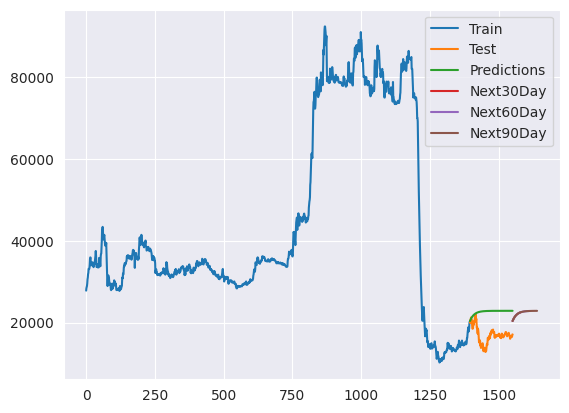

In [21]:
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(test_data.index, forecast)
plt.plot(last_data_30, y_next_30_days)
plt.plot(last_data_60, y_next_60_days)
plt.plot(last_data_90, y_next_90_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day', 'Next60Day', 'Next90Day'])

plt.show()

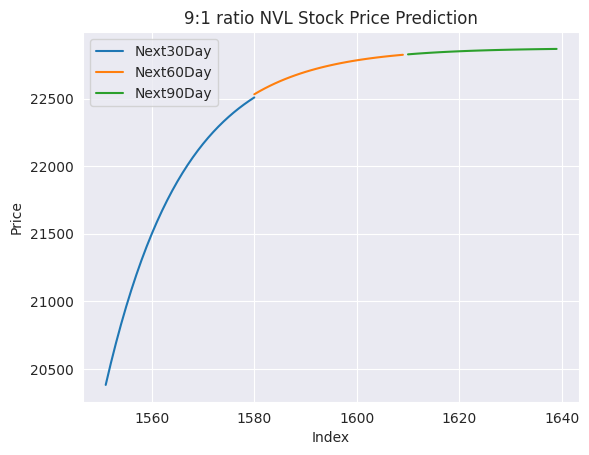

In [22]:
plt.plot(last_data_30, y_next_30_days)
plt.plot(range(last_data_30[-1], last_data_60[-1]), y_next_60_days[30:])
plt.plot(range(last_data_60[-1], last_data_90[-1]), y_next_90_days[60:])
plt.legend(['Train', 'Test', 'Predictions','Next30Day', 'Next60Day', 'Next90Day'])

# Adding labels and legend
plt.xlabel('Index')
plt.ylabel('Price')
plt.title('9:1 ratio NVL Stock Price Prediction')
plt.legend(['Next30Day', 'Next60Day', 'Next90Day'])

plt.show()